In [1]:
from fastmarching import *

In [2]:
from imageio import imread
from utils import perform_blurring, imageplot
import cv2
img = cv2.imread('../../data/vessels.png')

#crop = img[584-564:584, 1:565]

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

M = perform_blurring(gray,20)

f1 = M - gray

c = np.max(f1);
epsilon = 1e-2;
W = epsilon + np.abs(f1-c)
# Get brightness range - i.e. darkest and lightest pixels



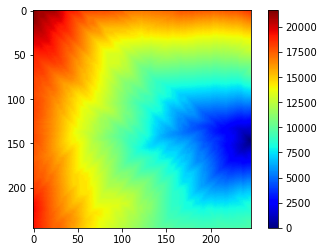

In [3]:

D = perform_fmm_2D([146,244],W)

In [7]:
import skfmm as fmm
def perform_fast_marching(D,start_points):
    """
        Implementation of the fast marching algorithm in 2Ds using the skfmm library
        D : 2D weight matrix, must be positive
        start_points : 2 x n array, start_points[:,i] is the ith starting point
    """
    D_temp = np.copy(D)
    D_temp[start_points[0,:],start_points[1,:]] = 0
    return fmm.distance(D_temp) + 1e-15

In [11]:
res = perform_fast_marching(1/W,np.array([[146],[244]]))

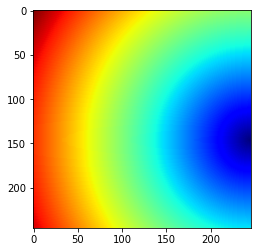

In [12]:
plt.imshow(res)

In [16]:
import numpy 
from scipy.ndimage.morphology import distance_transform_edt

def getMissingMask(slab):

    nan_mask=numpy.where(numpy.isnan(slab),1,0)
    if not hasattr(slab,'mask'):
        mask_mask=numpy.zeros(slab.shape)
    else:
        if slab.mask.size==1 and slab.mask==False:
            mask_mask=numpy.zeros(slab.shape)
        else:
            mask_mask=numpy.where(slab.mask,1,0)
    mask=numpy.where(mask_mask+nan_mask>0,1,0)

    return mask

def geodesic(img,seed):

    seedy,seedx=seed
    mask=getMissingMask(img)

    #----Call distance_transform_edt if no missing----
    if mask.sum()==0:
        slab=numpy.ones(img.shape)
        slab[seedy,seedx]=0
        return distance_transform_edt(slab)

    target=(1-mask).sum()
    dist=numpy.ones(img.shape)*numpy.inf
    dist[seedy,seedx]=0

    def expandDir(img,direction):
        if direction=='n':
            l1=img[0,:]
            img=numpy.roll(img,1,axis=0)
            img[0,:]==l1
        elif direction=='s':
            l1=img[-1,:]
            img=numpy.roll(img,-1,axis=0)
            img[-1,:]==l1
        elif direction=='e':
            l1=img[:,0]
            img=numpy.roll(img,1,axis=1)
            img[:,0]=l1
        elif direction=='w':
            l1=img[:,-1]
            img=numpy.roll(img,-1,axis=1)
            img[:,-1]==l1
        elif direction=='ne':
            img=expandDir(img,'n')
            img=expandDir(img,'e')
        elif direction=='nw':
            img=expandDir(img,'n')
            img=expandDir(img,'w')
        elif direction=='sw':
            img=expandDir(img,'s')
            img=expandDir(img,'w')
        elif direction=='se':
            img=expandDir(img,'s')
            img=expandDir(img,'e')

        return img

    def expandIter(img):
        sqrt2=numpy.sqrt(2)
        tmps=[]
        for dirii,dd in zip(['n','s','e','w','ne','nw','sw','se'],\
                [1,]*4+[sqrt2,]*4):
            tmpii=expandDir(img,dirii)+dd
            tmpii=numpy.minimum(tmpii,img)
            tmps.append(tmpii)
        img=reduce(lambda x,y:numpy.minimum(x,y),tmps)

        return img

    #----------------Iteratively expand----------------
    dist_old=dist
    while True:
        expand=expandIter(dist)
        dist=numpy.where(mask,dist,expand)
        nc=dist.size-len(numpy.where(dist==numpy.inf)[0])

        if nc>=target or numpy.all(dist_old==dist):
            break
        dist_old=dist

    return dist

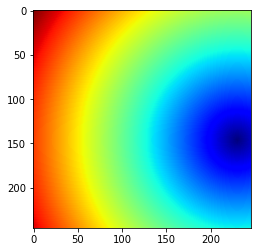

In [18]:
plt.imshow(geodesic(W,[146,230]))

In [6]:
from numba import jit

@jit
def test(x,y):
    square = lambda x: x*x
    return square(x) + y

In [2]:
from imageio import imread
import numpy as np
from utils import perform_blurring, imageplot
import cv2
img = cv2.cvtColor(cv2.imread('../../data/40_training.tif'), cv2.COLOR_BGR2RGB)

crop = img[584-564:584, 1:565]

gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)

M = perform_blurring(gray,20)

f1 = M - gray

c = np.max(f1);
epsilon = 1e-2;
W = epsilon + np.abs(f1-c)

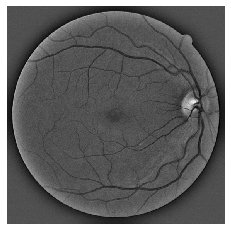

In [4]:
imageplot(W)

In [5]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

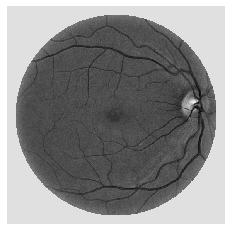

In [19]:
h, w = W.shape[:2]
mask = create_circular_mask(h, w,radius=260)
masked_img = W.copy()
masked_img[~mask] = 100
imageplot(masked_img)

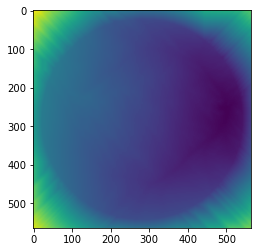

In [3]:
import numpy as np 
import matplotlib.pyplot as plt

plt.imshow(np.load('training_fmm/29_training.tif.npy'))

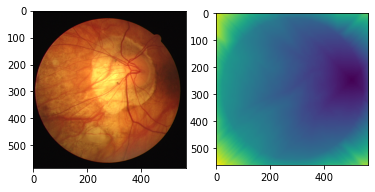

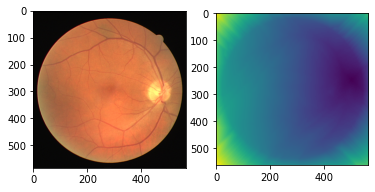

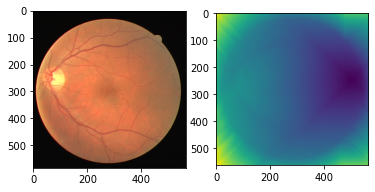

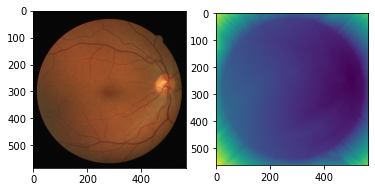

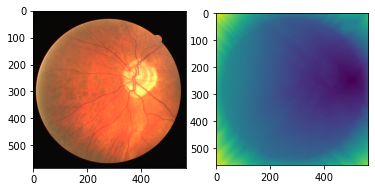

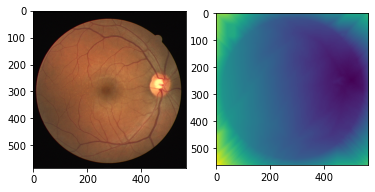

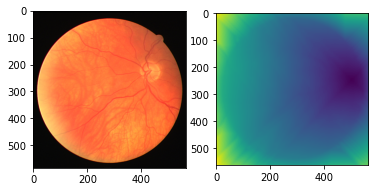

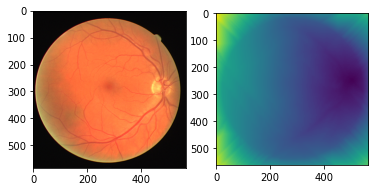

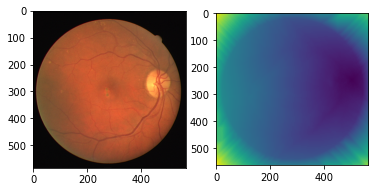

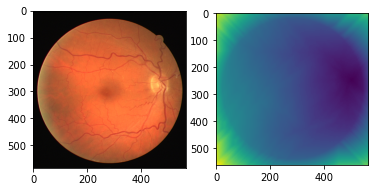

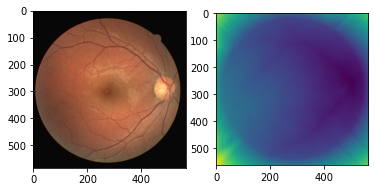

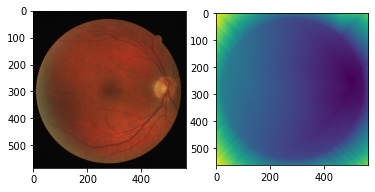

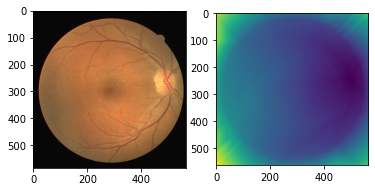

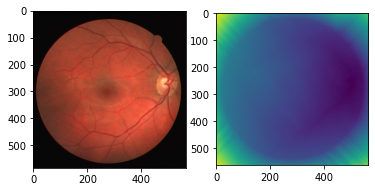

In [9]:
import os 
import numpy as np 
import matplotlib.pyplot as plt
import cv2

directories = os.listdir('training_fmm')
path = '../../data/training/images/'

for files in directories:
    img2 = cv2.cvtColor(cv2.imread(path + files[:11]+'.tif'), cv2.COLOR_BGR2RGB)
    img = np.load('training_fmm/' + files)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(img2)
    ax2.imshow(img)
    plt.show()

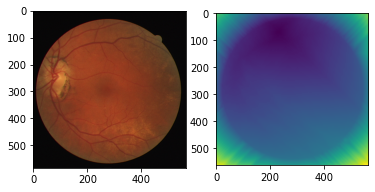

In [10]:
img2 = cv2.cvtColor(cv2.imread(path + '26_training'+'.tif'), cv2.COLOR_BGR2RGB)
img = np.load('training_fmm/26_training.npy')
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img2)
ax2.imshow(img)
plt.show()